# 手寫阿拉伯數字辨識 完整版

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：資料探索

In [4]:
train_ds.data.shape, train_ds.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
# 訓練資料前10筆圖片的數字
train_ds.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [6]:
# 顯示第1張圖片內含值
train_ds.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
# 將非0的數字轉為1，顯示第1張圖片
data = train_ds.data[0].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000001111111111110000',
 '0000000011111111111111110000',
 '0000000111111111111111100000',
 '0000000111111111110000000000',
 '0000000011111110110000000000',
 '0000000001111100000000000000',
 '0000000000011110000000000000',
 '0000000000011110000000000000',
 '0000000000001111110000000000',
 '0000000000000111111000000000',
 '0000000000000011111100000000',
 '0000000000000001111100000000',
 '0000000000000000011110000000',
 '0000000000000011111110000000',
 '0000000000001111111100000000',
 '0000000000111111111000000000',
 '0000000011111111110000000000',
 '0000001111111111000000000000',
 '0000111111111100000000000000',
 '0000111111110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [8]:
# 將非0的數字轉為1，顯示第2張圖片
data = train_ds.data[1].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000001111100000000',
 '0000000000000011111100000000',
 '0000000000000111111111000000',
 '0000000000011111111111000000',
 '0000000000011111111111000000',
 '0000000000111111111111000000',
 '0000000001111111110011100000',
 '0000000011111100000011100000',
 '0000000111111100000011100000',
 '0000000111100000000011100000',
 '0000000111000000000011100000',
 '0000001111000000000011100000',
 '0000001111000000001111100000',
 '0000001110000000011111000000',
 '0000001110000000111100000000',
 '0000001110000001111000000000',
 '0000001111111111111000000000',
 '0000001111111111100000000000',
 '0000001111111110000000000000',
 '0000000111111100000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

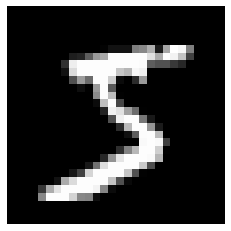

In [9]:
# 顯示第1張圖片圖像
import matplotlib.pyplot as plt

# 第一筆資料
X = train_ds.data[0]

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

## 步驟3：特徵工程，此步驟無需進行

In [10]:
# train_ds.data = train_ds.data / 255.0
# test_ds.data = test_ds.data / 255.0

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [11]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
    # 使用nn.CrossEntropyLoss()時，不需要將輸出經過softmax層，否則計算的損失會有誤
    # torch.nn.Softmax(dim=1)
).to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [12]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 設定優化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []    
correct = y_count = 0
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # if batch_idx == 0 and epoch == 1: print(data.shape)

        optimizer.zero_grad()
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()
        y_count += pred.shape[0]
        
        # if batch_idx == 0 and epoch == 1: print(output.shape, target.shape)
        loss = criterion(output, target)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            acc = correct / y_count
            correct = y_count = 0
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            print(f'Epoch {epoch + 1}: [{batch:5d} / {data_count}]' +
                  f'  Accuracy: {acc*100:.2f}%,  Loss: {loss.item():.6f}')

Epoch 1: [ 6000 / 60000]  Accuracy: 34.45%,  Loss: 2.065308
Epoch 1: [12000 / 60000]  Accuracy: 64.72%,  Loss: 1.831411
Epoch 1: [18000 / 60000]  Accuracy: 69.43%,  Loss: 1.661156
Epoch 1: [24000 / 60000]  Accuracy: 75.77%,  Loss: 1.383004
Epoch 1: [30000 / 60000]  Accuracy: 78.65%,  Loss: 1.230076
Epoch 1: [36000 / 60000]  Accuracy: 79.70%,  Loss: 1.034142
Epoch 1: [42000 / 60000]  Accuracy: 81.32%,  Loss: 1.011110
Epoch 1: [48000 / 60000]  Accuracy: 81.28%,  Loss: 0.841987
Epoch 1: [54000 / 60000]  Accuracy: 82.08%,  Loss: 0.766128
Epoch 1: [60000 / 60000]  Accuracy: 87.32%,  Loss: 0.602637
Epoch 2: [ 6000 / 60000]  Accuracy: 84.85%,  Loss: 0.622174
Epoch 2: [12000 / 60000]  Accuracy: 85.02%,  Loss: 0.695614
Epoch 2: [18000 / 60000]  Accuracy: 82.60%,  Loss: 0.698461
Epoch 2: [24000 / 60000]  Accuracy: 86.52%,  Loss: 0.590122
Epoch 2: [30000 / 60000]  Accuracy: 86.20%,  Loss: 0.630052
Epoch 2: [36000 / 60000]  Accuracy: 85.77%,  Loss: 0.512342
Epoch 2: [42000 / 60000]  Accuracy: 86.3

## CrossEntropyLoss 可接納 output, target 維度不同，[600, 10]及[600]

## 對訓練過程的損失繪圖

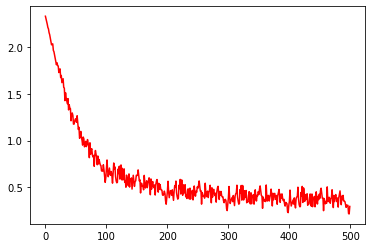

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [14]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=test_ds.targets.shape[0])

model.eval()
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)

    # sum up batch loss
    test_loss += criterion(output, target).item()

    # 預測
    pred = output.argmax(dim=1, keepdim=True)  

    # 正確筆數
    correct += pred.eq(target.view_as(pred)).sum().item()

# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均損失: 0.3356, 準確率: 9052/10000 (91%)



## 使用 torchmetrics

In [15]:
!pip install torchmetrics


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import torchmetrics

torchmetrics.functional.accuracy(pred.reshape(-1), test_ds.targets.to(device)
                                 , num_classes=10)

tensor(0.9052, device='cuda:0')

## 實際比對測試資料的前20筆

In [29]:
# 實際預測 20 筆資料
test_loader = DataLoader(test_ds, shuffle=False, batch_size=20)
for data, target in test_loader:
    data = data.to(device)
    pred = model(data)
    output = pred.argmax(dim=1, keepdim=True)
    predictions = output.cpu().numpy()
    break
    
# 比對
print('實際值:', ' '.join(target.numpy().astype(str)))
print('預測值:', ' '.join(predictions.astype(str).reshape(-1)))

實際值: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4
預測值: 7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


In [28]:
# 顯示第 9 筆的機率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'預測機率: {np.around(predictions.detach().cpu().numpy(), 2)}')
print(f'預測類別: {model(data).argmax(dim=1).item()}')

預測機率: [[0.01 0.   0.04 0.   0.03 0.01 0.9  0.   0.01 0.  ]]
預測類別: 6


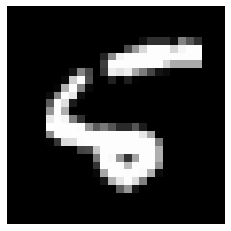

In [19]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0]
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [20]:
# 模型存檔
torch.save(model, 'model.pt')

# 模型載入
model = torch.load('model.pt')

In [21]:
# 權重存檔
torch.save(model.state_dict(), 'model.pth')

# 權重載入
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [22]:
# 顯示每一層的 state_dict 維度
print("每一層的 state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

每一層的 state_dict:
1.weight 	 torch.Size([256, 784])
1.bias 	 torch.Size([256])
3.weight 	 torch.Size([10, 256])
3.bias 	 torch.Size([10])


## 步驟10：新資料預測

In [24]:
# 使用小畫家，繪製 0~9，實際測試看看
from PIL import Image

# 讀取影像並轉為單色
# image to a Torch tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([28, 28]),
    transforms.PILToTensor()
])
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image = Image.open(uploaded_file)
    X1 = transform(image)
    X1 = torch.FloatTensor(255.0-X1).to(device)
    print(f'actual/prediction: {i} {model(X1).argmax(dim=1).item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 0
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 8


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [ ]:
print(model)

In [ ]:
# 顯示模型的彙總資訊
for name, module in model.named_children():
    print(f'{name}: {module}')

In [ ]:
!pip install torchinfo 

In [ ]:
from torchinfo import summary
summary(model, (60000, 28, 28)) # input dimension size

## PyTorch 無法繪製模型